# Определение стоимости автомобилей

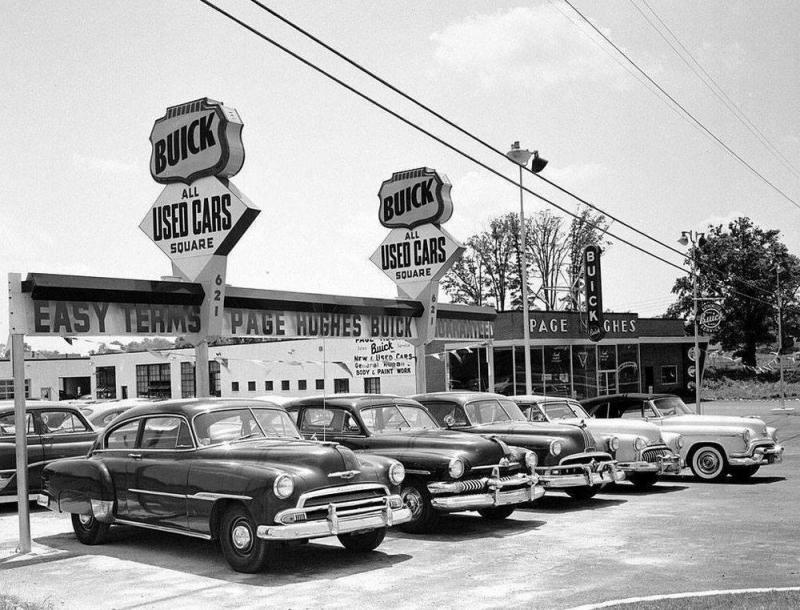

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

NotRepaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

**Целевой признак**

Price — цена (евро)

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
pd.options.mode.chained_assignment = None

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

from scipy import stats as st
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# заранее установим в константу random_state
STATE = np.random.RandomState(42)

дополнительные настройки

In [3]:
warnings.filterwarnings('ignore') 

In [6]:
df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

Функция вывода информации о датасете

In [5]:
def data_info(data):
    display('общая информация')
    display(data.head())
    display('_______________________________________________________________')
    display('информация о типах данныx')
    display()
    display(data.info())
    display('_______________________________________________________________')
    display('описание')
    display()
    display(data.describe())
    display('_______________________________________________________________')
    display('пропуски')
    display(df.isna().sum())
    display()
    display('_______________________________________________________________')
    display('дубликаты')
    display()
    display(data.duplicated().sum())
    display('_______________________________________________________________')
    display('корреляция')
    display()
    display(pd.DataFrame(data.corr()))

In [5]:
data_info(df)

'общая информация'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


'_______________________________________________________________'

'информация о типах данныx'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB


None

'_______________________________________________________________'

'описание'

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


'_______________________________________________________________'

'пропуски'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

'_______________________________________________________________'

'дубликаты'

4

'_______________________________________________________________'

'корреляция'

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


**Вывод:**

1. Данные представлены в датасете df

2. df содержит 354369 объектов и 16 признаков

 - столбцы DateCrawled, DateCreated, LastSeen с текстовыми данными представляет собой дату события (уже преобразовано в дату на этапе импорта) - тип данных datetime64
 
 - Price, RegistrationYear, Power, Kilometer, RegistrationMonth, NumberOfPictures, PostalCode - тип данных int64
 
 - VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired - тип данных object64 
 

3. Имеются пропуски типа NaN


4. Присутствуют 4 дубликата


5. Присутствует заметная линейная связь 0.65 признаков 'Страховые выплаты' и 'Возраст'

### Столбцы

для корректного анализа изменим названия признаков 

- приведение в нижний регистр
- разделение слов нижним подчеркиванием

In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gear_box',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
df.head(3)

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46


### Признаки

In [9]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Описание данных показывает наличие аномалий в данных:

1. registration_year. max = 9999, min = 1000

2. power. max = 20000, min = 0

Возможно проверить распределением.

### Пропуски

In [12]:
report = df.isna().sum().to_frame()
report.columns = ['missing_values']
report['%_of_total'] = (report['missing_values'] / df.shape[0] * 100).round(1)
display(report.sort_values(by='missing_values', ascending=False))

,missing_values,%_of_total
not_repaired,71154,20.1
vehicle_type,37490,10.6
fuel_type,32895,9.3
gear_box,19833,5.6
model,19705,5.6
date_crawled,0,0.0
price,0,0.0
registration_year,0,0.0
power,0,0.0
kilometer,0,0.0


Описание пропусков:

1. Причины не известны (потеря данных при сборе, копировании, и т.д. или не было изначально)

2. Все пропуски в категориальных данных - заменить на значение медианы или среднее не удастся.

3. Количество пропусков значительное - до 20 %

Удалим пропуски

In [13]:
df = df.dropna()

возможно, заменить на новые значения было бы лучше

In [14]:
report = df.isna().sum().to_frame()
report.columns = ['missing_values']
report['% of total'] = (report['missing_values'] / df.shape[0] * 100).round(1)
display(report.sort_values(by='missing_values', ascending=False))

,missing_values,% of total
date_crawled,0,0.0
price,0,0.0
vehicle_type,0,0.0
registration_year,0,0.0
gear_box,0,0.0
power,0,0.0
model,0,0.0
kilometer,0,0.0
registration_month,0,0.0
fuel_type,0,0.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245814 entries, 3 to 354367
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        245814 non-null  datetime64[ns]
 1   price               245814 non-null  int64         
 2   vehicle_type        245814 non-null  object        
 3   registration_year   245814 non-null  int64         
 4   gear_box            245814 non-null  object        
 5   power               245814 non-null  int64         
 6   model               245814 non-null  object        
 7   kilometer           245814 non-null  int64         
 8   registration_month  245814 non-null  int64         
 9   fuel_type           245814 non-null  object        
 10  brand               245814 non-null  object        
 11  not_repaired        245814 non-null  object        
 12  date_created        245814 non-null  datetime64[ns]
 13  number_of_pictures  245814 no

### Распределение, выбросы и аномалии

Проверим количество объектов, где год регистрации автомобиля более 2020 года и менее 1940

In [17]:
df.query('registration_year > 2020 or registration_year < 1940').count()

date_crawled          17
price                 17
vehicle_type          17
registration_year     17
gear_box              17
power                 17
model                 17
kilometer             17
registration_month    17
fuel_type             17
brand                 17
not_repaired          17
date_created          17
number_of_pictures    17
postal_code           17
last_seen             17
dtype: int64

Это аномалии - удаляем

In [18]:
df = df.query('1940 < registration_year < 2020')

Text(0.5, 0.98, 'Распределение года регистрации')

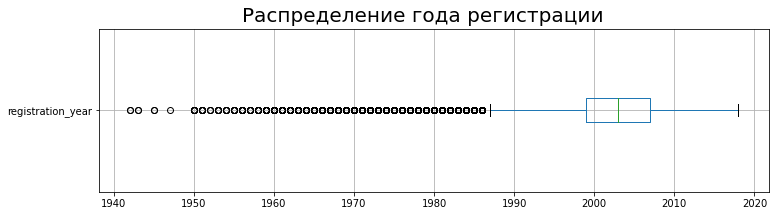

In [19]:
df.boxplot('registration_year', figsize = (12,3),vert=False)
plt.xlim()
plt.suptitle('Распределение года регистрации', size = 20)

Text(0, 0.5, 'частота')

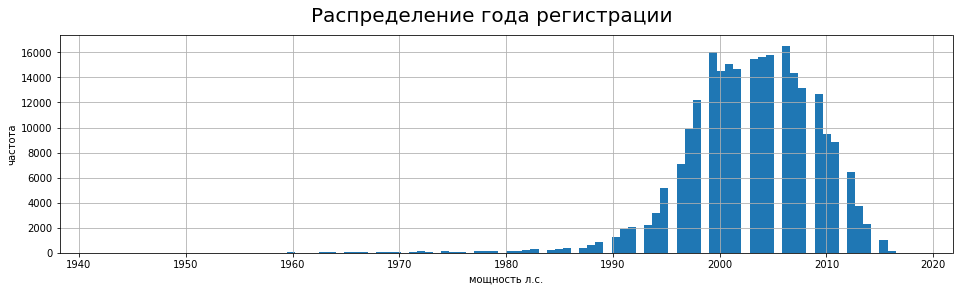

In [20]:
df['registration_year'].hist(bins = 100, figsize = (16, 4))
plt.xlim()
plt.ylim()
plt.suptitle('Распределение года регистрации', size = 20)
plt.xlabel('мощность л.с.')
plt.ylabel('частота')

Проверим количество объектов, где мощность автомобиля > 700 л.с. и < 50

In [21]:
df.query('power > 700').count()

date_crawled          141
price                 141
vehicle_type          141
registration_year     141
gear_box              141
power                 141
model                 141
kilometer             141
registration_month    141
fuel_type             141
brand                 141
not_repaired          141
date_created          141
number_of_pictures    141
postal_code           141
last_seen             141
dtype: int64

Это аномалии - удаляем

In [22]:
df = df.query('power < 700')

Количество аномалий power = 0 л.с. 

In [23]:
len(df.query('power < 50')) / len(df) * 100

5.230506197716309

Мощность автомобиля < 50, такие данные некорректные, восстановить или заменить не можем - удаляем

In [24]:
df = df.query('power > 50')

Text(0.5, 0.98, 'Распределение мощности автомобиля')

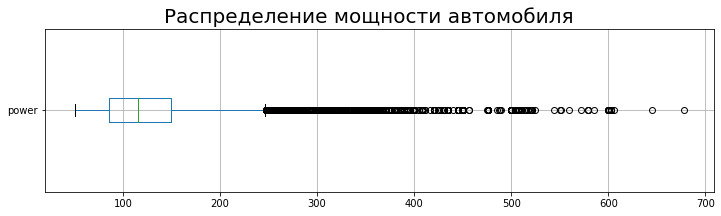

In [25]:
df.boxplot('power', figsize = (12,3),vert=False)
plt.xlim()
plt.suptitle('Распределение мощности автомобиля', size = 20)

Text(0, 0.5, 'частота')

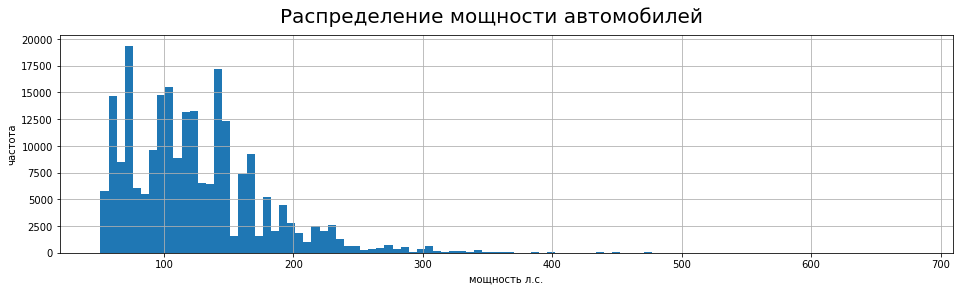

In [26]:
df['power'].hist(bins = 100, figsize = (16, 4))
plt.xlim()
plt.ylim()
plt.suptitle('Распределение мощности автомобилей', size = 20)
plt.xlabel('мощность л.с.')
plt.ylabel('частота')

### Дубликаты

Выявлено 4 дубликата - проверим данные

In [28]:
df[df.duplicated() == True]

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


Непонятно, выявленные дубликаты не содержат дублирующую информацию

### Корреляция

In [29]:
display(df.corr().style.background_gradient(cmap='summer'))

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
price,1.000000,0.579453,0.489194,-0.409603,0.037414,nan,0.058437
registration_year,0.579453,1.000000,0.112604,-0.408306,0.024962,nan,0.029235
power,0.489194,0.112604,1.000000,0.118090,0.027484,nan,0.045648
kilometer,-0.409603,-0.408306,0.118090,1.000000,-0.007804,nan,-0.011458
registration_month,0.037414,0.024962,0.027484,-0.007804,1.000000,nan,0.001485
number_of_pictures,nan,nan,nan,nan,nan,nan,nan
postal_code,0.058437,0.029235,0.045648,-0.011458,0.001485,nan,1.000000


Максимальная зависимость price-registration_year = .5, мультиколлинеарность отсутствует.

Анализ всей информации показывает, что признак number_of_pictures не содержит полезной информации - удаляем

In [30]:
df = df.drop(['number_of_pictures'] , axis=1)

<div class="alert alert-block alert-info">
Возможно, есть еще несколько неинформативных признаков, которые можно удалить
</div>

<div class="alert alert-info">
     
- date_crawled
    
- registration_year
    
- registration_month
    
- date_created
    
- postal_code
    
- last_seen

</div>

In [31]:
df = df.drop(['date_crawled', 'registration_year', 'registration_month', 'date_created', 'postal_code', 'last_seen'] , axis=1)

In [32]:
df.head(10)

,price,vehicle_type,gear_box,power,model,kilometer,fuel_type,brand,not_repaired
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no
10,2000,sedan,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,manual,140,passat,150000,gasoline,volkswagen,yes
14,17999,suv,manual,190,navara,70000,gasoline,nissan,no
17,1750,small,auto,75,twingo,150000,petrol,renault,no
18,7550,bus,manual,136,c_max,150000,gasoline,ford,no
19,1850,bus,manual,102,a_klasse,150000,petrol,mercedes_benz,no


## Обучение моделей

### Преобразование категориальных данных

Количество уникальных значений каждого признака

In [33]:
list = df.columns.to_list()
value = []
for column in list:
    value.append(df[column].nunique())
pd.DataFrame(index = [list, value])

,
price,3350
vehicle_type,8
gear_box,2
power,370
model,248
kilometer,13
fuel_type,7
brand,38
not_repaired,2


Необходимо преобразовать категориальные данные типа object:

- vehicle_type

- gear_box

- model

- fuel_type

- brand

- not_repaired

Преобразовать категориальные признаки в численные поможет техника прямого кодирования, или отображения (англ. One-Hot Encoding, OHE)

Посмотрим уникальные категории в каждом признаке

In [34]:
category_list = ['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand', 'not_repaired']
for cat in category_list:
    display(df[cat].unique())

array(['small', 'sedan', 'convertible', 'wagon', 'suv', 'bus', 'coupe',
       'other'], dtype=object)

array(['manual', 'auto'], dtype=object)

array(['golf', 'fabia', '3er', '2_reihe', '3_reihe', 'passat', 'navara',
       'twingo', 'c_max', 'a_klasse', 'scirocco', '5er', 'other', 'civic',
       'punto', 'e_klasse', 'one', 'clio', '1er', 'b_klasse', 'fortwo',
       'a8', 'jetta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
       'escort', 'forester', 'fiesta', 'scenic', 'a1', 'focus', 'tt',
       'astra', 'a6', 'jazz', 'transporter', 'polo', 'slk', '7er',
       'combo', '80', '147', 'meriva', 'z_reihe', 'ibiza', 'mustang',
       'eos', 'a4', 'touran', 'getz', 'insignia', 'megane', 'a3', 'r19',
       'colt', 'corsa', 'vectra', 'lupo', 'berlingo', 'tiguan', '6_reihe',
       'c4', 'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe',
       'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', 'mondeo', '6er',
       'fox', 'matiz', 'beetle', 'rio', 'touareg', 'logan', 'omega',
       'cuore', 's_max', 'modus', 'a2', 'galaxy', 'c3', 'viano',
       's_klasse', 'sharan', 'avensis', 'roomster', 'sl', 'santa', 'leon',
      

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

array(['volkswagen', 'skoda', 'bmw', 'peugeot', 'mazda', 'nissan',
       'renault', 'ford', 'mercedes_benz', 'honda', 'fiat', 'mini',
       'smart', 'audi', 'alfa_romeo', 'subaru', 'mitsubishi', 'opel',
       'seat', 'hyundai', 'lancia', 'citroen', 'toyota', 'kia',
       'chevrolet', 'dacia', 'suzuki', 'daihatsu', 'chrysler', 'volvo',
       'jaguar', 'rover', 'porsche', 'jeep', 'saab', 'daewoo',
       'land_rover', 'lada'], dtype=object)

array(['no', 'yes'], dtype=object)

In [31]:
df = pd.get_dummies(df, drop_first=True)

Анализ перечня моделей на предмет неявных дубликатов признака model.

In [35]:
data = ['golf', 'fabia', '3er', '2_reihe', '3_reihe', 'passat', 'navara',
       'twingo', 'c_max', 'a_klasse', 'scirocco', '5er', 'other', 'civic',
       'punto', 'e_klasse', 'one', 'clio', '1er', 'b_klasse', 'fortwo',
       'a8', 'jetta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
       'escort', 'forester', 'fiesta', 'scenic', 'a1', 'focus', 'tt',
       'astra', 'a6', 'jazz', 'transporter', 'polo', 'slk', '7er',
       'combo', '80', '147', 'meriva', 'z_reihe', 'ibiza', 'mustang',
       'eos', 'a4', 'touran', 'getz', 'insignia', 'megane', 'a3', 'r19',
       'colt', 'corsa', 'vectra', 'lupo', 'berlingo', 'tiguan', '6_reihe',
       'c4', 'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe',
       'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', 'mondeo', '6er',
       'fox', 'matiz', 'beetle', 'rio', 'touareg', 'logan', 'omega',
       'cuore', 's_max', 'modus', 'a2', 'galaxy', 'c3', 'viano',
       's_klasse', 'sharan', 'avensis', 'roomster', 'sl', 'santa', 'leon',
       'cooper', 'sportage', 'caddy', 'clk', 'primera', '4_reihe',
       'espace', 'exeo', 'juke', 'x_reihe', 'v40', 'accord', 'corolla',
       'grand', 'phaeton', 'cordoba', 'verso', 'rav', 'qashqai', '159',
       'swift', 'picanto', 'boxster', 'stilo', 'alhambra', 'ka',
       'roadster', 'ypsilon', 'galant', 'sirion', 'signum', 'crossfire',
       'agila', 'duster', 'sorento', 'v50', 'mx_reihe', 'c_reihe',
       'v_klasse', 'm_klasse', 'yaris', 'c5', 'aygo', 'almera', 'cc',
       '911', 'bora', 'a5', 'cl', 'tigra', '300c', '500', 'ptcruiser',
       '100', 'cr_reihe', 'xc_reihe', 'spark', 'kuga', 'laguna',
       'impreza', 'x_type', 'ducato', 's_type', 'x_trail', 'toledo',
       'altea', 'voyager', 'carnival', 'v70', 'bravo', 'forfour',
       'carisma', 'transit', 'c1', 'kadett', 'citigo', 'jimny', 'cayenne',
       'wrangler', 'lybra', 'lancer', 'captiva', 'fusion', 'discovery',
       'sandero', '1_reihe', 'q7', 'note', 'spider', '90', 'antara',
       'cherokee', 'seicento', 'clubman', 'defender', 'arosa', 'cx_reihe',
       'legacy', 'pajero', 'c2', 'niva', 's60', '900', 'nubira', 'vivaro',
       'lanos', 'tucson', 'g_klasse', 'freelander', 'auris', 'lodgy',
       'range_rover', '850', 'superb', 'q3', 'justy', 'serie_2',
       'calibra', 'glk', 'charade', 'croma', 'outlander', 'kaefer',
       'doblo', 'musa', '9000', 'kalos', 'v60', '200', 'm_reihe', 'b_max',
       '145', 'range_rover_sport', 'aveo', 'q5', 'move',
       'range_rover_evoque', 'materia', 'terios', 'gl', 'kalina',
       'elefantino', 'delta', 'i3', 'samara', 'amarok', 'serie_3',
       'kappa', 'rangerover']

In [33]:
df_model = pd.DataFrame(data=data , columns=['1']) 
df_model.sort_values(by='1')

,1
152,100
230,145
44,147
27,156
118,159
184,1_reihe
18,1er
227,200
3,2_reihe
149,300c


<div class="alert alert-info">
    
Добавил анализ неявных дубликатов признака model.
    
Значительного количества явный дублей не обнаружено и их количество сократить не удастся.

</div>

### Преобразование данных datetime

In [36]:
#df[['date_crawled', 'date_created', 'last_seen']] = df[['date_crawled', 'date_created', 'last_seen']].astype(np.int64) // 10**9

<div class="alert alert-info">
    
Раздел **2.2  Преобразование данных datetime** не актуален - признаки 'date_crawled', 'date_created', 'last_seen' удалены

</div>

### Масштабирование признаков

numeric = ['power', 'kilometer', 'postal_code']

numeric = ['power', 'kilometer']

scaler = StandardScaler()

scaler.fit(df[numeric])

df[numeric] = scaler.transform(df[numeric])

df.head(3)

### Выделение целевого признака

In [35]:
x = df.drop(['price'] , axis=1)

In [36]:
y = df['price']

### Разделение выборки на train, test, valid

Разделяем исходные данные предварительно на промежуточную обучающую 80% и валидационную выборку 20% - для получения равных валидационной и тестовой выборок

In [37]:
x_train_1, x_valid, y_train_1, y_valid = train_test_split(x, y, test_size=0.2, random_state=STATE)

Разделяем полученные данные на обучающую 75% и тестовую выборки 25%.

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_train_1, y_train_1, test_size=0.25, random_state=STATE)

In [39]:
len(df) - len(x_train) - len(x_test) - len(x_valid)

0

Сброс индексов и удаление признака index

In [40]:
df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

После разделения имеем следующие выборки

1. обучающая выборка

   x_train - признаки   
   y_train - целевой признак
   
   
2. валидационная выборка

   x_valid - признаки   
   y_valid - целевой признак
   
   
3. тестовая выборка

   x_test - признаки   
   y_test - целевой признак

### Масштабирование признаков

In [41]:
numeric = ['power', 'kilometer']

In [42]:
scaler = StandardScaler()

In [43]:
scaler.fit(x_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [44]:
x_train[numeric] = scaler.transform(x_train[numeric])

In [45]:
x_train.head(3)

,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gear_box_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_volkswagen,brand_volvo,not_repaired_yes
94739,0.475056,0.618094,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Обучение модели LinearRegression и предсказание на валидационной выборке.

инициализация модели LinearRegression

обучение модели на тренировочной выборке

предсказание модели на валидационной выборке

In [46]:
%%time
model_linear_regression = LinearRegression()
model_linear_regression = model_linear_regression.fit(x_train, y_train)

CPU times: user 10.3 s, sys: 3.35 s, total: 13.7 s
Wall time: 13.7 s


In [47]:
%%time
predictions_valid_linear_regression = model_linear_regression.predict(x_valid)

CPU times: user 78.5 ms, sys: 75.1 ms, total: 154 ms
Wall time: 134 ms


### Обучение модели Decision Tree Regressor и предсказание на валидационной выборке.

In [48]:
%%time

model_Decision_Tree_Regressor = DecisionTreeRegressor(random_state=STATE)

params_Decision_Tree_Regressor = {
    'max_depth':[x for x in range(8, 10, 1)], 
    'min_samples_leaf':[x for x in range(6, 8, 1)],
    'min_samples_split':[x for x in range(60, 80, 10)],
}

model_Decision_Tree_Regressor = GridSearchCV(model_Decision_Tree_Regressor, params_Decision_Tree_Regressor, cv=5)
model_Decision_Tree_Regressor.fit(x_train, y_train)

CPU times: user 1min 33s, sys: 5.39 s, total: 1min 38s
Wall time: 1min 39s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False,
                                             random_state=RandomState(MT19937) at 0x7FC62B294380,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [8, 9], 'min_samples_leaf': [6, 7],
                         'min_samples_split': [60, 70]},
  

In [49]:
print(model_Decision_Tree_Regressor.best_params_)

{'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 70}


In [50]:
%%time
predictions_valid_Decision_Tree_Regressor = model_Decision_Tree_Regressor.predict(x_valid)

CPU times: user 54.8 ms, sys: 36.8 ms, total: 91.6 ms
Wall time: 106 ms


### Обучение модели Random Forest Regressor и предсказание на валидационной выборке.

In [51]:
model_Random_Forest_Regressor = RandomForestRegressor(random_state=STATE)

In [55]:
#Сетка поиска сокращена для экономии времени

params_Random_Forest_Regressor = {
    'n_estimators':[x for x in range(50, 51, 1)],
    'max_depth':[x for x in range(6, 7, 1)], 
    'min_samples_leaf':[x for x in range(6, 7, 1)],
    'min_samples_split':[x for x in range(40, 41, 1)],
}

<div class="alert alert-info">
    
Обучение модели запущено с предустановленными праметрами для экономии времени
    
для анализа время обучение будет принято = 1ч.30 мин.   


</div>

In [56]:
%%time

model_Random_Forest_Regressor = GridSearchCV(
    
    model_Random_Forest_Regressor, params_Random_Forest_Regressor, cv=5)

model_Random_Forest_Regressor.fit(x_train, y_train)

CPU times: user 4min 58s, sys: 1.14 s, total: 4min 59s
Wall time: 5min 2s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=RandomState(MT19937) at 0x7FC62B294380,
                                             verbose=0, warm_start=False),
             ii

In [57]:
%%time
predictions_Random_Forest_Regressor = model_Random_Forest_Regressor.predict(x_valid)

CPU times: user 119 ms, sys: 56.2 ms, total: 175 ms
Wall time: 193 ms


{'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 40, 'n_estimators': 50}

### Обучение модели CatBoostRegressor и предсказание на валидационной выборке.

In [58]:
%%time 

model_Cat_Boost_Regressor = CatBoostRegressor()
model_Cat_Boost_Regressor.fit(x_train, y_train)

0:	learn: 4668.0974135	total: 134ms	remaining: 2m 13s
1:	learn: 4593.5581641	total: 239ms	remaining: 1m 59s
2:	learn: 4523.7465460	total: 427ms	remaining: 2m 21s
3:	learn: 4456.2236154	total: 533ms	remaining: 2m 12s
4:	learn: 4392.6842827	total: 724ms	remaining: 2m 24s
5:	learn: 4331.2201229	total: 836ms	remaining: 2m 18s
6:	learn: 4270.6342280	total: 935ms	remaining: 2m 12s
7:	learn: 4215.2756125	total: 1.13s	remaining: 2m 19s
8:	learn: 4159.9530576	total: 1.24s	remaining: 2m 16s
9:	learn: 4106.0611346	total: 1.43s	remaining: 2m 21s
10:	learn: 4055.1543588	total: 1.62s	remaining: 2m 25s
11:	learn: 4007.4436886	total: 1.82s	remaining: 2m 29s
12:	learn: 3959.6534332	total: 1.93s	remaining: 2m 26s
13:	learn: 3912.8126445	total: 2.03s	remaining: 2m 22s
14:	learn: 3870.2109432	total: 2.13s	remaining: 2m 19s
15:	learn: 3827.9153076	total: 2.32s	remaining: 2m 22s
16:	learn: 3787.1252490	total: 2.42s	remaining: 2m 20s
17:	learn: 3747.4515226	total: 2.53s	remaining: 2m 17s
18:	learn: 3710.4273

In [59]:
%%time
predictions_Cat_Boost_Regressor = model_Cat_Boost_Regressor.predict(x_valid)

CPU times: user 198 ms, sys: 37.1 ms, total: 235 ms
Wall time: 214 ms


<div class="alert alert-block alert-info">
можно было бы попробовать внутренний метод кодировки данных.
</div> 

## Анализ моделей

Проведем анализ качества полученных моделей RMSE с учетом времени обучения

In [60]:
rmse_Linear_Regression = mean_squared_error(y_valid, predictions_valid_linear_regression)**.5

In [61]:
rmse_Decision_Tree_Regressor = mean_squared_error(y_valid, predictions_valid_Decision_Tree_Regressor)**.5

In [62]:
rmse_Random_Forest_Regressor = mean_squared_error(y_valid, predictions_Random_Forest_Regressor)**.5

In [63]:
rmse_CatBoostRegressor = mean_squared_error(y_valid, predictions_Cat_Boost_Regressor)**.5

In [69]:
data = {'model':['Linear_Regression', 'Decision_Tree_Regressor', 'Random_Forest_Regressor',  'CatBoostRegressor'],
        'fit_time':['0m13.7s', '1m39s', '1h30m', '2m01s'], 'predict_time':['134ms', '106ms', '193ms', '214ms'],
        'RMSE':[rmse_Linear_Regression, rmse_Decision_Tree_Regressor, rmse_Random_Forest_Regressor, rmse_CatBoostRegressor]
       }
 
# Создать DataFrame
pd.set_option('display.float_format', '{:.10g}'.format)
models = pd.DataFrame(data)
models.sort_values(by='RMSE')

,model,fit_time,predict_time,RMSE
2,Random_Forest_Regressor,1h30m,193ms,8895.557382
3,CatBoostRegressor,2m01s,214ms,9129.719717
1,Decision_Tree_Regressor,1m39s,106ms,9218.733634
0,Linear_Regression,0m13.7s,134ms,280221734.8


Из полученных данных видно, что при анализе качества моделей на валидационной выборке по времени обучения и по уровню качества значительно выигрывает модель линейной регрессии.

<div class="alert alert-info">
    
**Вывод** 
    
Из полученных данных видно:
    
1. Наилучшее качество у модели Random_Forest_Regressor, но время обучения значительно больше остальных моделей
    
2. Качество моделей CatBoostRegressor и Decision_Tree_Regressor немного хуже, чем  Random_Forest_Regressor, но при этом время обучения значительно ниже.
    
3. Самое низкое качество (неприемлемое) показала модель Linear_Regression, хотя время обучения наилучшее. 
    
4. Время предсказания наименьшее у модели Decision_Tree_Regressor
    
**Итог: модель Decision_Tree_Regressor с приемлемым уровнем качества и временем обучения, а так же с минимальным временем предсказания принимаем , как наиболее оптимальную в этой задаче.** 


</div>

<div class="alert alert-block alert-info">
Необходимо делать итоговый вывод поподробнее, подчеркивая ключевые моменты. Заказчик в первую очередь будет обращать основное внимание на эту часть проекта.
</div> 